# Exp 9. 폐렴 진단기 성능개선

# 🗼 목차

Step 0. 라이브러리 불러오기  
    
Step 1. 실험환경 Set-up  
    
Step 2. 데이터 준비하기  
    2.1 train, test, val 데이터  
    2.2 정상 이미지 & 폐렴 이미지  
    2.3 tf.data 인스턴스 만들기 (train, val 데이터)  
    2.4 라벨 데이터 생성 & 이미지 리사이징 (train, val 데이터)  
    2.5 tf.data 인스턴스 만들기 (test 데이터)  
    2.6 데이터 변환 + augmentation  
    
Step 3. 데이터 시각화  
    
Step 4. CNN 모델링  
    4.1 Convolution block 만들기  
    4.2 Dense Block 만들기  
    4.3 모델링  
    
Step 5. 데이터 imbalance 처리  
    
Step 6. 모델 훈련  
    
Step 7. 결과 확인

# 💡 폐렴 진단
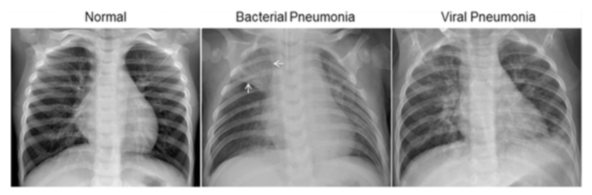  
* 정상 : 이미지에서 비정상적인 음영 영역이 없이 깨끗함
* 세균성 폐렴 : 오른쪽 상부 엽(흰색 화살표) 쪽에 음영 영역이 있음
* 바이러스성 폐렴 :양쪽 폐 주변에 확산되어 음영 영역이 있음

---

# Step 0. 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

---

# Step 1. 실험환경 Set-up
* Batch size를 처음에 16 → 32로 변경을 하였으나, 16으로 하였을 때, 더 좋은 성능을 보여서 다시 16으로 변경하여 진행하였다.
* EPOCH는 많이 할수록 더 나은 성능을 보이는 것 같아 25 → 30으로 늘렸다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


---

# Step 2. 데이터 준비하기

## 2.1 train, test, val 데이터
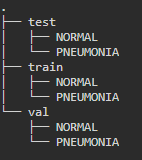

In [3]:
# 파일 경로를 파일 이름으로 가져옴
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train 데이터의 개수: ', len(train_filenames))
print('test 데이터의 개수: ', len(test_filenames))
print('val 데이터의 개수: ', len(val_filenames))

train 데이터의 개수:  5216
test 데이터의 개수:  624
val 데이터의 개수:  16


* train, test, val 데이터 비율이 89%, 10.7%, 0.3%로 val 데이터의 개수가 거의 없는 것을 확인할 수 있다.  
    → train 데이터에서 더 가져오기로 한다.
* train, val 데이터를 합한 후, train : val을 80:20으로 분할하고자 한다.

In [4]:
# train 데이터와 validation 데이터를 모두 'filenames'에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# train과 val 데이터가 합쳐진 'filenames'를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)   # math.floor : 숫자 내림 함수
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train 데이터의 개수: ',len(train_filenames))
print('test 데이터의 개수: ',len(test_filenames))
print('val 데이터의 개수: ', len(val_filenames))

train 데이터의 개수:  4185
test 데이터의 개수:  624
val 데이터의 개수:  1047


## 2.2 정상 이미지 & 폐렴 이미지

* 정상이미지와 폐렴이미지를 구분해야 하는데, 파일 경로에 힌트가 있으니 파일 경로를 통해 구분하고자 한다.  
    → 파일 경로에 NORMAL이 있으면 : 정상 이미지  
    → 파일 경로에 PNEUMONIA가 있으면 : 폐렴 이미지

In [5]:
print(f'정상이미지 파일 경로 : \n{filenames[0]}')
print(f'폐렴이미지 파일 경로 : \n{filenames[2000]}')

정상이미지 파일 경로 : 
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
폐렴이미지 파일 경로 : 
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


* 폐렴 이미지가 정상 이미지보다 3배가 많은 것을 확인할 수 있다.
* 우리가 사용할 CNN 모델의 경우, 데이터가 클래스 별 balance가 좋을수록 training을 잘한다.  
    → 그래서 imbalance한 데이터를 조정할 예정
* test, val 데이터는 평가하기 위해 사용되니 imbalance한 데이터셋이여도 문제 없다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"train 데이터에 있는 정상 이미지 개수: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"train 데이터에 있는 폐렴 이미지 개수: {COUNT_PNEUMONIA}")

train 데이터에 있는 정상 이미지 개수: 1072
train 데이터에 있는 폐렴 이미지 개수: 3113


## 2.3 tf.data 인스턴스 만들기 (train, val 데이터)
* TensorFlow에서는 `Dataset`이라는 built-in-API를 제공한다.
* `Dataset`은 입력 파이프라인을 만들어서 모델에 데이터를 효율적으로 공급한다.
* `tf.data`는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.
* train, validation, test 데이터 모두 tf.data 인스턴스를 만들어보자.
* tf. data : https://cyc1am3n.github.io/2018/09/13/how-to-use-dataset-in-tensorflow.html

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames) # numpy 배열이 있고 그걸 tensorflow로 넣기
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()   # tf.data.dataset의 모양을 얻는 방법
print('train 데이터의 개수: ', TRAIN_IMG_COUNT)

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('val 데이터의 개수: ', VAL_IMG_COUNT)

train 데이터의 개수:  4185
val 데이터의 개수:  1047


## 2.4 라벨 데이터 생성 & 이미지 리사이징 (train, val 데이터)

* PNEUMONIA(폐렴)인 데이터를 찾아 라벨 데이터를 생성한다.  
    → 파일 경로의 끝에서 두번째 부분에 `"PNEUMONIA"`이 있으면 폐렴 이미지(데이터)이다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지의 사이즈를 통일시키고 줄이는 작업을 하고자 한다.
* `process_path`함수 안에서 `decode_img`함수로 이미지의 데이터 타입을 float로 변경한다.
* 그리고 위에서 생성한 함수인 `get_label`함수를 이용해서 라벨 값을 가져온다.

In [10]:
# 이미지의 데이터 타입과 사이즈 변경하는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하여 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 위에서 만든 get_label 함수를 이용해 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* 사이즈와 라벨 값을 적용한 train, validation 데이터 셋을 만든다.

In [11]:
# num_parallel_calls 파라미터에 AUTOTUNE 변수를 이용하면 빠르게 데이터를 처리할 수 있음

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* train 데이터가 리사이징이 잘 되었는지, 라벨이 잘 들어갔는지 확인해보자.

In [12]:
for image, label in train_ds.take(1):     # 하나의 데이터만 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


## 2.5 tf.data 인스턴스 만들기 (test 데이터)
* test 데이터도 tf.data 인스턴스로 만든다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('val 데이터의 개수: ', TEST_IMAGE_COUNT)

val 데이터의 개수:  624


## 2.6 데이터 변환 + augmentation
* tf.data 파이프라인을 이용하여 `prepare_for_training()`함수를 정의해 데이터를 변환

* 데이터가 많지 않기 위해 augmentation 기법을 사용하였다.
* 랜덤하게 좌우를 반전시키는 augmentation 기법을 사용하여 진행하였다. augmentation 기법을 사용하였을 때의 성능이 더 좋아 좌우반전 augmentation 기법을 계속 사용하였다.
* 좌우반전 augmentation 기법 이외에 밝기 조절, 대비 조절 등의 augmentation을 시도하였으나 에러가 나 실패하였다.
* [data augmentation 코드 참고한 URL](https://runebook.dev/ko/docs/tensorflow/-index-#tf.image)

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)   # 고정 크기 버퍼 유지 & 무작위로 선택
    ds = ds.repeat()     # 여러번 데이터 셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE)    # 정한 만큼의 배치로 주어짐
    ds = ds.prefetch(buffer_size=AUTOTUNE)   # 학습 데이터를 나눠서 읽어오기에 리소스의 유휴 상태를 줄일 수 있음
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

---

# Step 3. 데이터 시각화
* 데이터를 확인해보기 위해 train에 있는 batch 중 첫번째 배치 추출하였다.
* 추출된 배치를 image와 label 데이터셋으로 나누었다.
* `show_batch()`함수를 이용해 결과 사진 볼 수 있다.
* augmentation 기법을 사용했으니, **좌우반전**이 되었는지 확인을 해볼 필요가 있다.

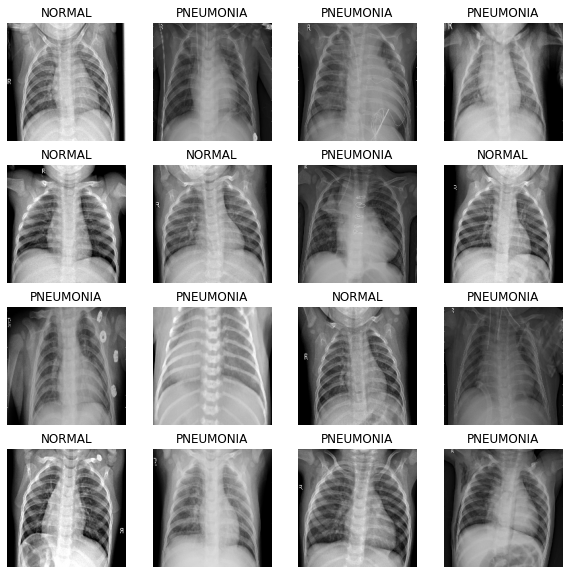

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

---

# Step 4. CNN 모델링
* BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용했는데, 이 구성을 변경한다면 어떤 효과가 발생하는지 실험해보라고 하셔서 해보았다.

## 4.1 Convolution block 만들기
* Convolution 2번 진행
* Batch Normalization을 통해 Gradient vanishing, Gradient Exploding을 해결
* Max Pooling 진행
* 이번주 월,수요일에 CNN에 대해 배우면서 아래의 코드를 읽을 수 있게 되었다.
* 그래서 필터의 사이즈를 변경하면 어떻게 될까 라는 생각으로 3 → 5로 변경하였고 성능은 향상하였다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 5, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

## 4.2 Dense Block 만들기
* BatchNormalization, activation, dropout의 순서가 중요하다는 글을 봐서 순서를 변경하여 진행을 하였으나 성능이 매우 안 좋았다.  
    ▶ [참고한 글](https://gaussian37.github.io/dl-concept-order_of_regularization_term/)
* Dropout만 사용하고 BatchNormalization을 사용하지 않았는데, 역시나 성능이 좋지 않았다.
* BatchNormalization만 사용하고 Dropout을 사용하지 않았는데, 이것도 성능이 좋지 않았다.
* 위와 같은 결과로, Dense Block은 건드리지 않기로 했다....

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

## 4.3 모델링
* 여기에도 Convolution Block과 같이 Conv layer의 필터 사이즈를 3 → 5로 키워서 진행하였다.
* dropout 비율을 0.2 → 0.4로 변경하였는데 accuracy이 매우매우 떨어졌다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 5, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 5, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---

# Step 5. 데이터 imbalance 처리
* 데이터가 imbalance할 경우, 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용된다.
* Weight balancing  
    → training set의 각 데이터에서 loss를 계산할 때, 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.
* Keras는 model.fit()을 호출할 때, 파라미터인 class_weight에 클래스 별 가중치를 세팅할 수 있도록 지원한다.
* [class weight 관련 자료](https://3months.tistory.com/414)  
    
    
* imbalance 처리를 생략한다면 어떻게 될까 라고 생각되어 처리를 하지 않았는데, 성능이 좋지 않아서 imbalance는 처리하는 것이 좋다고 판단되었다.

In [20]:
# 전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# Normal 이미지에 사용할 weight, Pneumonia 이미지에 사용할 weight 셋팅
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


---

# Step 6. 모델 훈련
* GPU를 사용한다.
* 모델 : build_model()을 model에 선언한다.
* loss : 'binary_crossentropy' 사용 → 이미지의 라벨이 2개 밖에 없기에
* optimizer : adam
* 성과측정 metrics :'accuracy', 'precision', 'recall'

* optimizer를 adam이 아닌 다른 것으로 변경한다면 어떨까라는 생각에 다른 것으로 변경하고 성능확인을 하였지만 좋지 않아서 adam으로 진행하였다.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
261/261 [==============================] - 62s 191ms/step - loss: 0.4822 - accuracy: 0.7840 - precision: 0.9265 - recall: 0.7708 - val_loss: 0.6747 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 50s 192ms/step - loss: 0.3012 - accuracy: 0.8726 - precision: 0.9603 - recall: 0.8643 - val_loss: 0.7908 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 51s 194ms/step - loss: 0.2564 - accuracy: 0.9052 - precision: 0.9650 - recall: 0.9055 - val_loss: 0.5113 - val_accuracy: 0.7692 - val_precision: 0.7612 - val_recall: 1.0000
Epoch 4/50
261/261 [==============================] - 51s 195ms/step - loss: 0.2263 - accuracy: 0.9128 - precision: 0.9724 - recall: 0.9085 - val_loss: 0.0863 - val_accuracy: 0.9683 - val_precision: 0.9790 - val_recall: 0.9777
Epoch 5/50
261/261 [==============================] - 52s 201ms/step - loss: 0.2107 - accura

---

# Step 7. 결과 확인
* Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 그래프로 확인할 수 있다.
* 이전 그래프와 다르게 엄청 위 아래로 왔다갔다하는 그래프가 만들어졌다.

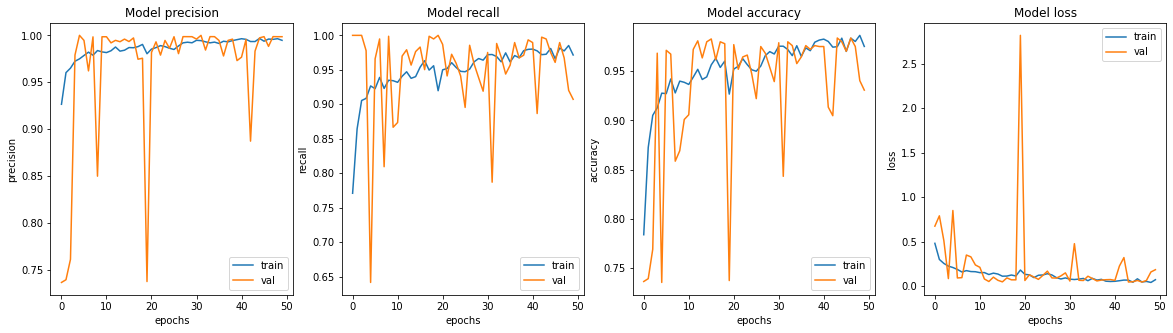

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* 테스트 데이터로 평가한 각 평가 지표들을 출력한다.

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.4725 - accuracy: 0.8654 - precision: 0.8626 - recall: 0.9333
Loss: 0.4725252389907837,
Accuracy: 0.8653846383094788,
Precision: 0.8625592589378357,
Recall: 0.9333333373069763


---
---
---

# 🌞 회고

## 1) 프로젝트를 진행하면서 궁금했던 점
* 폐렴 진단의 경우, 폐렴일 때 폐렴이라고 진단하는 것이 가장 중요하기에 recall값을 봐야하는 것이 아닌가라는 생각을 하였다.
* 하지만 프로젝트를 다양하게 시도해본 결과, accuracy는 낮게 나오는데 recall은 항상 0.95 이상으로 나왔다.
* recall은 높은데, accuracy가 낮게 나오는 이유는 무엇일까라는 생각을 해보았지만 명확한 해답을 찾지는 못하였다. 폐렴이 아닐 때 폐렴이라고 진단하는 오류가 커서 accuracy가 잘 나오지 않는건가 라는 생각을 해보았다.

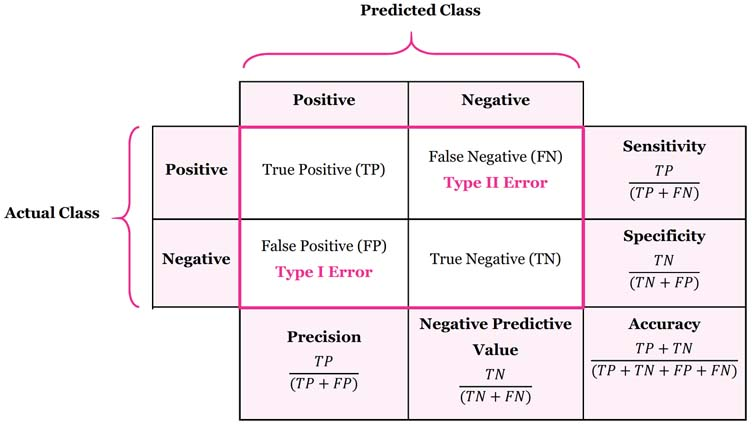

## 2) augmentation
* 이번 프로젝트에서 중요한 부분은 'data augmentation'였던 것 같은데, 다양한 augmentation을 구현하지 못한 것이 가장 아쉬웠다.
* 하지만 폐렴 이미지를 augmentation하는 방식이 한정되어 있다고 생각하였다. 뒤집거나 회전, 노이즈 추가하는 등 이러한 기법들은 오히려 폐렴 진단에 있어서 혼란을 야기하지 않을까라는 생각이 들었다. 그래서 밝기나 채도를 변경하는 augmentation을 진행하고 싶었으나 실패했다..

## 3) 결과
* 하나씩 다른 것들을 시도하면서 accuracy가 증가하긴 하였지만 85%를 넘지 못하였다.
* 에포크를 25 → 30으로 진행을 하다가, 에포크를 더 늘려보는건 어떨까라는 생각으로 에포크를 조금 극단적으로 50까지 늘려서 진행하였다.
* 에포크를 50으로 늘리니까 accuracy가 0.86까지 올라가는 것을 볼 수 있다. 하지만 recall값은 0.93으로 감소하였다.
* 루브릭은 맞추었으나 결과에 대한 궁금증이 해소되지 않아서 이 부분은 조금 아쉽다.

## 4) 느낀점
* 이번 프로젝트에서는 다양한 것들을 변경해보고 시도를 해보라고 노드에 적혀있어서 그거에 맞춰 다양하게 시도를 해보았는데, 결과는 기존의 것으로 진행하는 것이 가장 좋았다.
* 또 풀잎스쿨 시간에 CNN을 공부해서 이번 프로젝트에서 Conv Layer에 대해 정확하게 알 수 있었고, 공부한 것을 써먹기 위해 필터 사이즈도 변경해보았다. 그런데 변경한 것이 성능이 좋아서 조금 놀랬기도 했다.
* 다른 분들이 'callback' 개념에 대해 알려주셔서 사용해볼까 했었는데, 마침 수요일 혼공머 시간에 callback에 대해 배웠다. 그래서 해당 부분을 이번 프로젝트에서 사용해보았다. 하지만 callback을 사용하지 않고 에포크를 계속 돌린 것이 더욱 성능이 좋아서 callback은 따로 사용하지 않았다. 하지만 배운 것을 직접 써먹을 수 있어서 좋았다.
* 이번 프로젝트에서는 내가 풀잎스쿨 시간에 공부를 하였던 개념이 코드를 볼 때 보이고 이것을 사용하였다는 것에서 나름 큰 의미가 있었다.